In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline


In [2]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
# Note transforms.ToTensor() scales input images
# to 0-1 range

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor()
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "./data/flowers/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, 
                                              is_valid_file=check_image)

val_data_path = "./data/flowers/valid/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, 
                                            is_valid_file=check_image)
batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = None 

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

print(('load data ---> done!'))

load data ---> done!


In [3]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


In [4]:
it = iter(train_data_loader)

dt,target = it.next()
print(dt[1].shape)
print(target)

with open('./data/flowers_cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
n
print(cat_to_name['6'])

torch.Size([3, 224, 224])
tensor([13, 12,  3, 15,  3,  3,  9,  3,  1,  3,  3, 15, 13,  2, 11,  9,  5,  2,
         1, 15, 10,  7, 14,  5, 11,  4,  0, 13,  8,  9,  9,  8])
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': '

torch.Size([3, 224, 224])
<class 'torch.Tensor'>
(224, 224, 3)
4


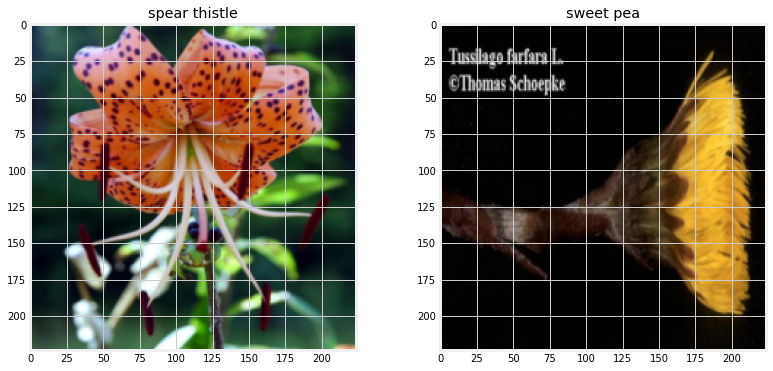

In [5]:
print(dt[9].shape)
check_img1 = dt[0].numpy()
check_img2 = dt[9].numpy()
print(type(dt[9]))
print(check_img1.transpose(1, 2, 0).shape)
ck1_idx = target[0].numpy() + 1
ck2_idx = target[9].numpy() + 1
print(ck2_idx)

# 显示图片
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
axes[0].imshow(check_img1.transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0].title.set_text(cat_to_name[str(ck1_idx)])
axes[1].imshow(check_img2.transpose(1, 2, 0))
axes[1].title.set_text(cat_to_name[str(ck2_idx)])
plt.show()

In [6]:
################################
# network
################################

class AlexNet(nn.Module):
    def __init__(self,num_classes=1000):
        super(AlexNet,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=96,out_channels=192,kernel_size=5,stride=1,padding=2,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=0),
            nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    def forward(self,x):
        x = self.feature_extraction(x)
        x = x.view(x.size(0),256*6*6)
        x = self.classifier(x)
        return x
    

In [7]:
alexnet = AlexNet(num_classes=num_classes)
alexnet

input = torch.randn(8,3,224,224)
out = alexnet(input)
print(out.shape)

torch.Size([8, 17])


In [8]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=50, device="cpu"):
    print('---- Training ----')
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch, training_loss, valid_loss, num_correct / num_examples))

In [9]:
alexnet.to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

### Training model

In [10]:
# Training model

train(alexnet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=50, device=device)

---- Training ----
---- Validating ----
Epoch: 0,  Training Loss: 2.87, Validation Loss: 3.15, accuracy = 0.08
---- Validating ----
Epoch: 1,  Training Loss: 2.80, Validation Loss: 2.55, accuracy = 0.18
---- Validating ----
Epoch: 2,  Training Loss: 2.40, Validation Loss: 2.30, accuracy = 0.15
---- Validating ----
Epoch: 3,  Training Loss: 2.11, Validation Loss: 1.97, accuracy = 0.30
---- Validating ----
Epoch: 4,  Training Loss: 2.00, Validation Loss: 1.98, accuracy = 0.30
---- Validating ----
Epoch: 5,  Training Loss: 1.89, Validation Loss: 1.81, accuracy = 0.31
---- Validating ----
Epoch: 6,  Training Loss: 1.77, Validation Loss: 1.62, accuracy = 0.42
---- Validating ----
Epoch: 7,  Training Loss: 1.70, Validation Loss: 1.61, accuracy = 0.37
---- Validating ----
Epoch: 8,  Training Loss: 1.53, Validation Loss: 1.63, accuracy = 0.45
---- Validating ----
Epoch: 9,  Training Loss: 1.44, Validation Loss: 1.53, accuracy = 0.55
---- Validating ----
Epoch: 10,  Training Loss: 1.41, Validat

### Test

In [12]:
test_data_path = "./data/flowers/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, 
                                             is_valid_file=check_image)
batch_size=64
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()

alexnet.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_data_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = alexnet(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_data_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 3.53, accuracy = 0.65
